## In this notebook, we will explore ARIMA.

# ARIMA
Autoregressive Integrated Moving Average (ARIMA) is a commonly-used local statistical algorithm for time-series forecasting. ARIMA captures standard temporal structures (patterned organizations of time) in the input dataset. 

The ARIMA algorithm is especially useful for datasets that can be mapped to stationary time series. The statistical properties of stationary time series, such as autocorrelations, are independent of time. Datasets with stationary time series usually contain a combination of signal and noise. The signal may exhibit a pattern of sinusoidal oscillation or have a seasonal component. ARIMA acts like a filter to separate the signal from the noise, and then extrapolates the signal in the future to make predictions.

We will use statsmodels to explore ARIMA first. [Statsmodels](https://www.statsmodels.org/stable/about.html#module-statsmodels) is a Python module that provides classes and functions for the estimation of many different statistical models, as well as for conducting statistical tests, and statistical data exploration. An extensive list of result statistics are available for each estimator. 

In [1]:
%matplotlib inline

import sys
from dateutil.parser import parse
import json
from random import shuffle
import random
import datetime
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
from decouple import config
rcParams['figure.figsize'] = 15, 6

In [2]:
# 2019-07-10 00:00:00 to 2019-10-09 23:59:59

DATETIME_START_OF_TRAIN = config('DATETIME_START_OF_TRAIN')
DATETIME_END_OF_TRAIN = config('DATETIME_END_OF_TRAIN')
DATETIME_START_OF_TEST = config('DATETIME_START_OF_TEST')
DATETIME_END_OF_TEST = config('DATETIME_END_OF_TEST')
DATETIME_START_OF_PREDICT = config('DATETIME_START_OF_PREDICT')
DATETIME_END_OF_PREDICT = config('DATETIME_END_OF_PREDICT')

# we use 1 day frequency for the time series
freq = config('freq')

# we predict for 7 days
prediction_length = config('prediction_length', cast=int)

# we also use 14 days as context length, this is the number of state updates accomplished before making predictions
context_length = config('context_length', cast=int)

sample_sites = config('sample_sites', cast=lambda v: [int(s.strip()) for s in v.split(',')])

In [3]:
start_dataset = pd.Timestamp(DATETIME_START_OF_TRAIN, freq=freq)
end_training = pd.Timestamp(DATETIME_END_OF_TRAIN, freq=freq)
start_predict = pd.Timestamp(DATETIME_START_OF_PREDICT, freq=freq)
end_predict = pd.Timestamp(DATETIME_END_OF_PREDICT, freq=freq)

Read time series data from csv. Then convert dataframe to a list with datetime index.

In [4]:
FILE_NAME = 'data/timeseries_raw.csv'

In [5]:
data = pd.read_csv(FILE_NAME, sep=",", index_col=0, parse_dates=True, decimal=',')
data.index = pd.DatetimeIndex(data.index,freq="1D")

num_timeseries = data.shape[1]

timeseries = []
for i in range(num_timeseries):
    timeseries.append(np.trim_zeros(data.iloc[:,i], trim='f').astype(float))

As there are 1604 stores in the data, we can use index from timeseries to extract one store's sales data. Here we use store 88 for example, you can try other id. 

In [6]:
import statsmodels.api as sm

Plot the data first.

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


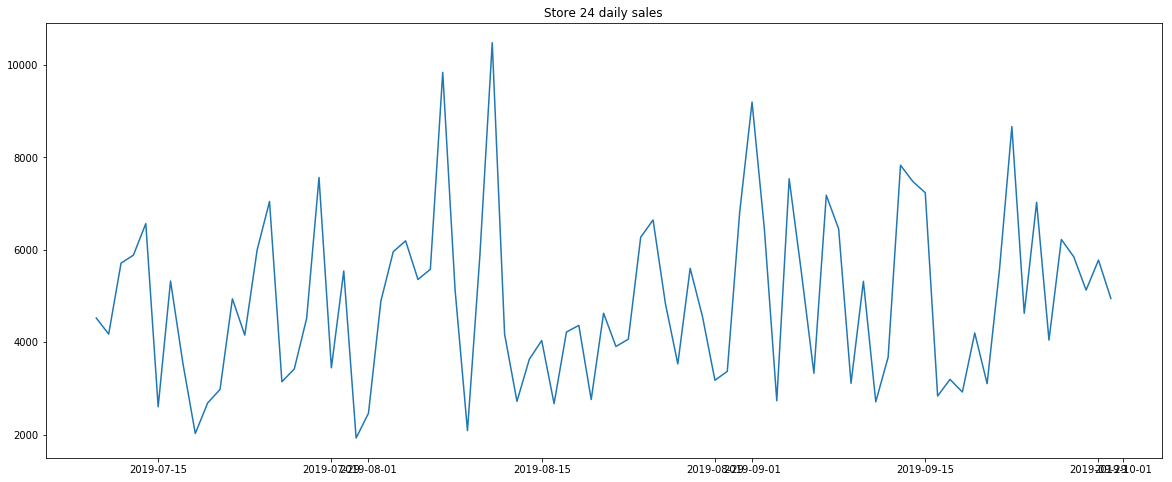

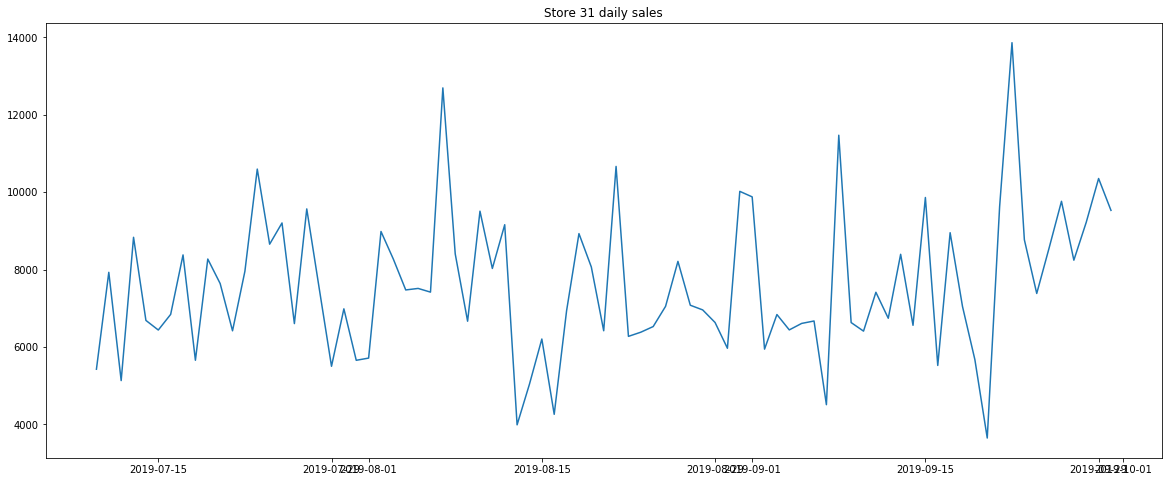

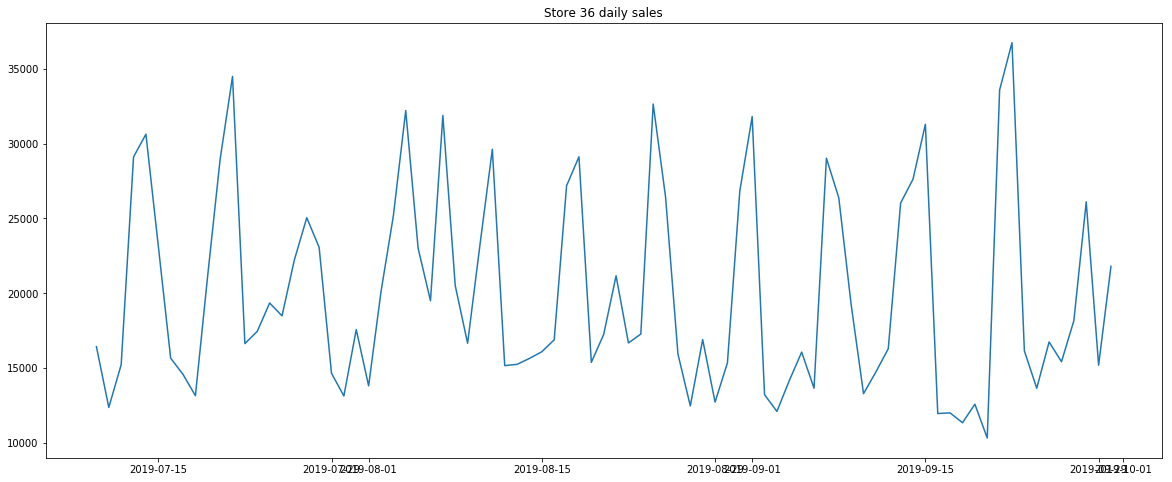

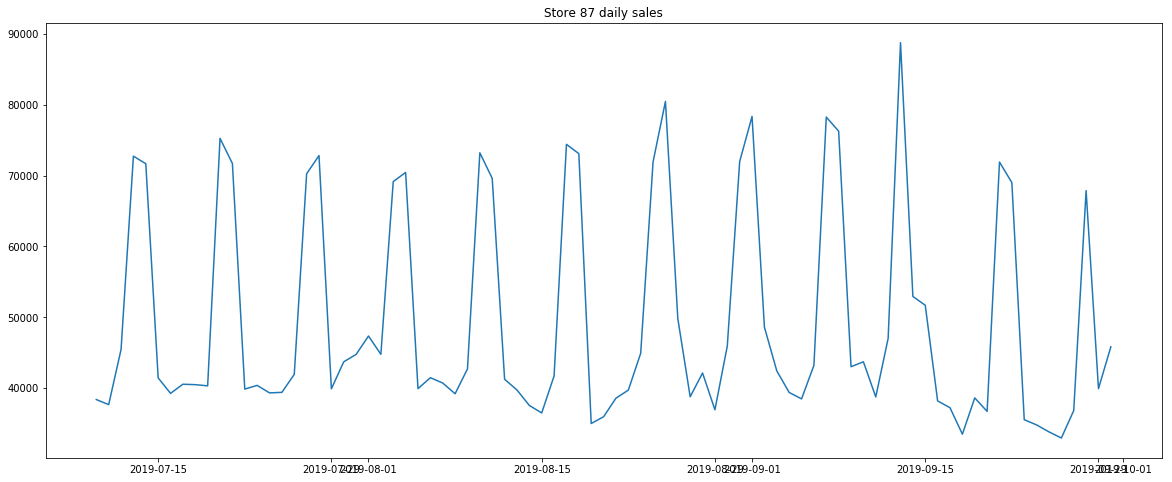

In [7]:
for i in sample_sites:
    ts = timeseries[i]
    fig = plt.figure(figsize=(20, 8))
    plt.plot(ts)
    plt.title('Store %s daily sales'%i)
    plt.show()

We can see it looks like stationary, but with a little trend, we can use Dickey-Fuller Test to caculate the truth.

Non-seasonal ARIMA models are generally denoted ARIMA(p,d,q) where parameters p, d, and q are non-negative integers, p is the order (number of time lags) of the autoregressive model, d is the degree of differencing (the number of times the data have had past values subtracted), and q is the order of the moving-average model. Seasonal ARIMA models are usually denoted ARIMA(p,d,q)(P,D,Q)m, where m refers to the number of periods in each season, and the uppercase P,D,Q refer to the autoregressive, differencing, and moving average terms for the seasonal part of the ARIMA model. [For more introduce](https://en.wikipedia.org/wiki/Autoregressive_integrated_moving_average)

So for us, we need determine the value of (p,d,q).

In [8]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=12).mean()
    rolstd = timeseries.rolling(window=12).std()
 
    #Plot rolling statistics:
    fig = plt.figure(figsize=(12, 8))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

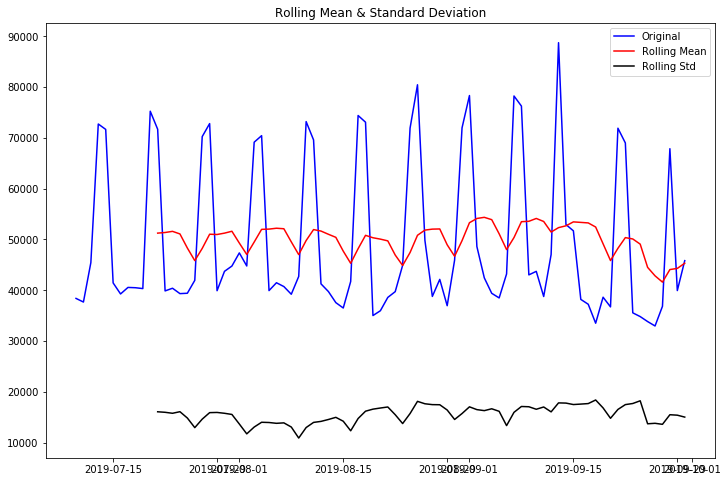

Results of Dickey-Fuller Test:
Test Statistic                 -1.927898
p-value                         0.319053
#Lags Used                      6.000000
Number of Observations Used    76.000000
Critical Value (1%)            -3.519481
Critical Value (5%)            -2.900395
Critical Value (10%)           -2.587498
dtype: float64


In [9]:
# choose timeseries[87] for example
ts = timeseries[87]
test_stationarity(ts)

The p-value is not less than 0.05, let's do order 1 diff.

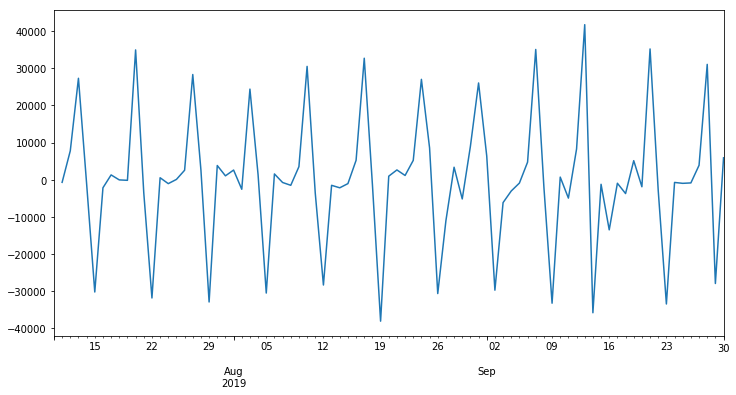

In [10]:
diff1 = ts.diff(1)
diff1.plot(figsize=(12,6))

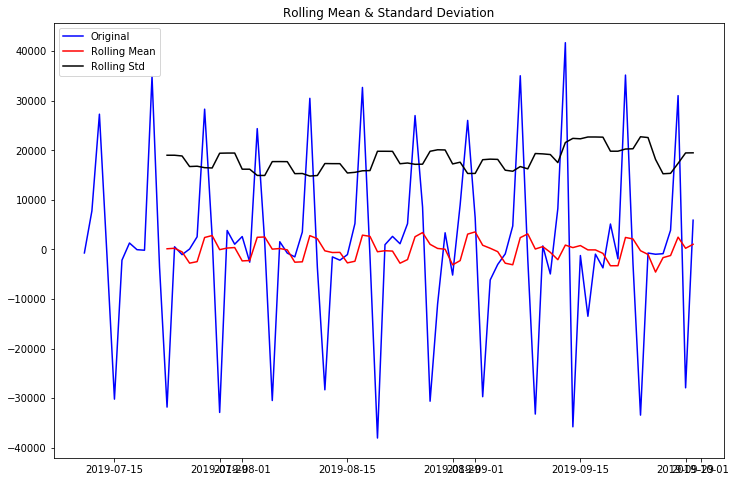

Results of Dickey-Fuller Test:
Test Statistic                 -4.053413
p-value                         0.001155
#Lags Used                     12.000000
Number of Observations Used    69.000000
Critical Value (1%)            -3.528890
Critical Value (5%)            -2.904440
Critical Value (10%)           -2.589656
dtype: float64


In [11]:
test_stationarity(diff1.dropna(inplace=False))

Now the p-value < 0.05 and Test Statistic < Critical Value (5%), we can use d = 1.

Plot ACF and PACF to find best value for p,q.

/home/ec2-user/.local/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1358: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


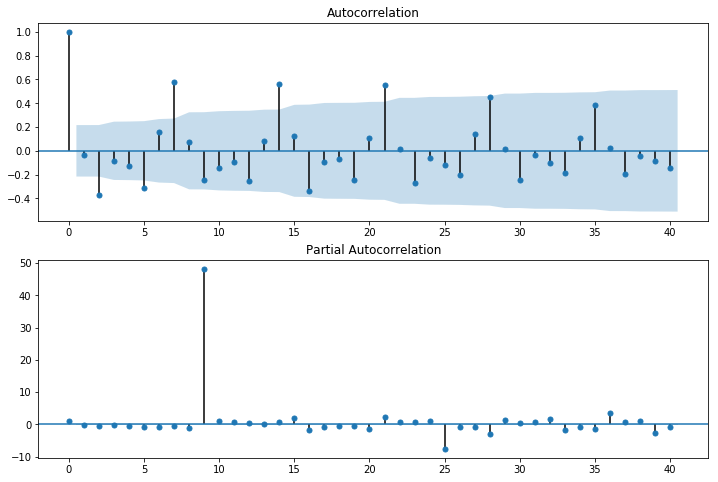

In [12]:
diff1.dropna(inplace=True)
fig = plt.figure(figsize=(12,8))
ax1=fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(diff1,lags=40,ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(diff1,lags=40,ax=ax2)

Try (p,d,q) = (3,1,0) first

In [13]:
from statsmodels.tsa.arima_model import ARIMA
from random import random

In [14]:
# contrived dataset
df_train = ts[start_dataset:start_predict-1]
df_predict=ts[start_predict:end_predict-1]

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:2: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`
  from ipykernel import kernelapp as app
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:3: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`
  app.launch_new_instance()


In [15]:
# fit model
model = ARIMA(df_train, order=(3, 1, 0))
model_fit = model.fit(disp=False)
# make prediction
yhat = model_fit.predict(start=start_predict, end=end_predict-1,typ='levels')
print(yhat)

2019-09-24    34022.279477
2019-09-25    48473.259104
2019-09-26    52694.195705
2019-09-27    46719.643450
2019-09-28    43490.559846
2019-09-29    45670.951255
2019-09-30    47729.722003
Freq: D, dtype: float64


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:5: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`


In [16]:
model_fit.params

const         40.326226
ar.L1.D.87    -0.048815
ar.L2.D.87    -0.417024
ar.L3.D.87    -0.126268
dtype: float64

Plot the predict result with groundtruth.

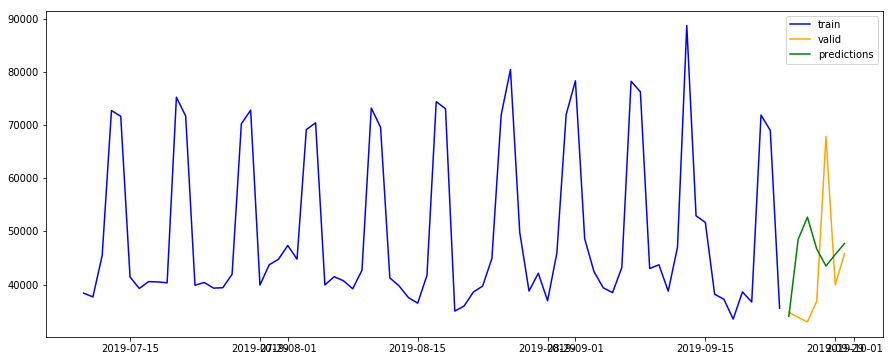

In [17]:
rcParams['figure.figsize'] = 15, 6
train_data = plt.plot(df_train, color='blue',label="train")
valid_data = plt.plot(df_predict, color='orange',label="valid")
predict_data = plt.plot(yhat, color='green',label="predictions")
plt.legend(loc="best")
plt.show()

You can try diffenent combination of (p,d,q), it is really hard to choose the value of (p,d,q), the good thing is we have **auto arima** to help us to choose, next we will show this.

In [18]:
# if you get an error about not install setuptools-git, then run under command.
#!pip install setuptools-git

In [19]:
!pip install pyramid-arima

    100% |████████████████████████████████| 604kB 4.7MB/s ta 0:00:01
You are using pip version 10.0.1, however version 19.3.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [20]:
from pyramid.arima import auto_arima

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/pyramid/__init__.py:68: UserWarning: 
    The 'pyramid' package will be migrating to a new namespace beginning in 
    version 1.0.0: 'pmdarima'. This is due to a package name collision with the
    Pyramid web framework. For more information, see Issue #34:
    
        https://github.com/tgsmith61591/pyramid/issues/34
        
    The package will subsequently be installable via the name 'pmdarima'; the
    only functional change to the user will be the import name. All imports
    from 'pyramid' will change to 'pmdarima'.
    
  """, UserWarning)


We can assign the start value and max value of (p,d,q), then it will search the proper value for us. For params specific, check http://alkaline-ml.com/pmdarima/0.9.0/modules/generated/pyramid.arima.auto_arima.html

We will consider weekly seasonal. 

In [21]:
model = auto_arima(df_train, trace=True, seasonal=True, d=1, start_p=1, max_p =10, start_q=1, max_q=10, m=7, maxiter=500, random=False, n_fits=100, n_jobs =8, information_criterion ='bic', error_action='ignore', suppress_warning=True)

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/pyramid/arima/auto.py:379: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  'Falling back to stepwise parameter search.' % n_jobs)
/home/ec2-user/.local/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:993: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 0, 1, 7); AIC=1599.653, BIC=1613.558, Fit time=0.533 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 0, 0, 7); AIC=1683.947, BIC=1688.582, Fit time=0.006 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 0, 0, 7); AIC=1659.552, BIC=1668.822, Fit time=0.031 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 0, 1, 7); AIC=1649.707, BIC=1658.977, Fit time=0.228 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 0, 1, 7); AIC=1662.760, BIC=1674.348, Fit time=0.056 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(2, 0, 1, 7); AIC=1651.424, BIC=1667.647, Fit time=0.105 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 0, 0, 7); AIC=1622.463, BIC=1634.051, Fit time=0.395 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 0, 2, 7); AIC=1652.312, BIC=1668.534, Fit time=0.122 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 0, 0, 7); AIC=1676.700, BIC=1685.970, Fit time=0.028 seconds


/home/ec2-user/.local/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:981: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/home/ec2-user/.local/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:993: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


Fit ARIMA: order=(1, 1, 1) seasonal_order=(2, 0, 2, 7); AIC=1653.422, BIC=1671.962, Fit time=0.172 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 0, 1, 7); AIC=1599.172, BIC=1610.759, Fit time=0.492 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(1, 0, 1, 7); AIC=1650.288, BIC=1659.558, Fit time=0.046 seconds


/home/ec2-user/.local/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:993: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
/home/ec2-user/.local/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:961: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/ec2-user/.local/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:993: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


Fit ARIMA: order=(0, 1, 2) seasonal_order=(1, 0, 1, 7); AIC=1598.488, BIC=1612.393, Fit time=0.448 seconds


/home/ec2-user/.local/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:961: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/ec2-user/.local/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:993: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


Fit ARIMA: order=(1, 1, 2) seasonal_order=(1, 0, 1, 7); AIC=1599.351, BIC=1615.574, Fit time=0.744 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(2, 0, 1, 7); AIC=1650.523, BIC=1664.428, Fit time=0.096 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 0, 0, 7); AIC=1621.549, BIC=1630.819, Fit time=0.170 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 0, 2, 7); AIC=1651.237, BIC=1665.141, Fit time=0.100 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 0, 0, 7); AIC=1686.005, BIC=1692.958, Fit time=0.012 seconds


/home/ec2-user/.local/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:981: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


Fit ARIMA: order=(0, 1, 1) seasonal_order=(2, 0, 2, 7); AIC=1609.089, BIC=1625.311, Fit time=1.239 seconds
Total fit time: 5.032 seconds


In [22]:
forecast = model.predict(n_periods=7)
forecast

array([39274.43541118, 40970.02453024, 41966.99662672, 49371.17191503,
       71286.30676919, 71514.56988517, 42805.99929971])

In [23]:
model.params()

array([ 8.47780321e-02, -9.99999594e-01,  9.97736525e-01, -8.96252580e-01,
        7.50462657e+07])

Show out modle's parameters.

In [24]:
model.get_params()['order']

(0, 1, 1)

In [25]:
def plot_predictions(forecast,store_id):
    ts = timeseries[store_id]
    df_train = ts[start_dataset:start_predict-1]
    df_predict=ts[start_predict:end_predict-1]
    
    rcParams['figure.figsize'] = 15, 6
    forecast = pd.DataFrame(forecast, index=df_predict.index, columns=['Predictions'])
    train_data = plt.plot(df_train, color='blue',label="train")
    valid_data = plt.plot(df_predict, color='orange',label="valid")
    predict_data = plt.plot(forecast, color='green',label="predictions")
    plt.title('Store %s prediction result' %store_id)
    plt.legend(loc="best")
    plt.show()

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:3: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`
  app.launch_new_instance()
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:4: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`


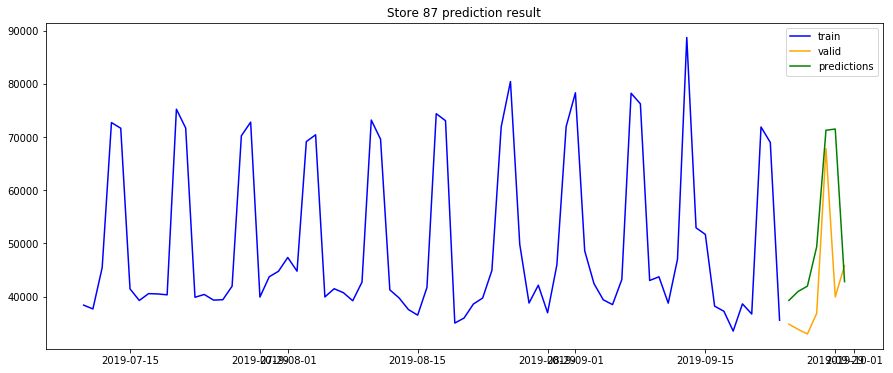

In [26]:
plot_predictions(forecast,87)

It fits better than before.

Now You can try other values combination or other time series, here we just want to show how to use it. We will plot 4 timeseries for example.


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:3: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`
  app.launch_new_instance()
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:4: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/pyramid/arima/auto.py:379: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  'Falling back to stepwise parameter search.' % n_jobs)


Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 0, 1, 7); AIC=1346.109, BIC=1360.014, Fit time=0.488 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 0, 0, 7); AIC=1386.895, BIC=1391.530, Fit time=0.005 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 0, 0, 7); AIC=1384.937, BIC=1394.207, Fit time=0.021 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 0, 1, 7); AIC=1358.008, BIC=1367.278, Fit time=0.182 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 0, 1, 7); AIC=1357.252, BIC=1368.839, Fit time=0.342 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(2, 0, 1, 7); AIC=1342.313, BIC=1358.535, Fit time=0.969 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(2, 0, 0, 7); AIC=1354.578, BIC=1368.483, Fit time=0.349 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(2, 0, 2, 7); AIC=1343.100, BIC=1361.640, Fit time=0.979 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 0, 0, 7); AIC=1357.145, BIC=1368.733, Fit time=0.198 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_o

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:3: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`
  app.launch_new_instance()
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:4: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`


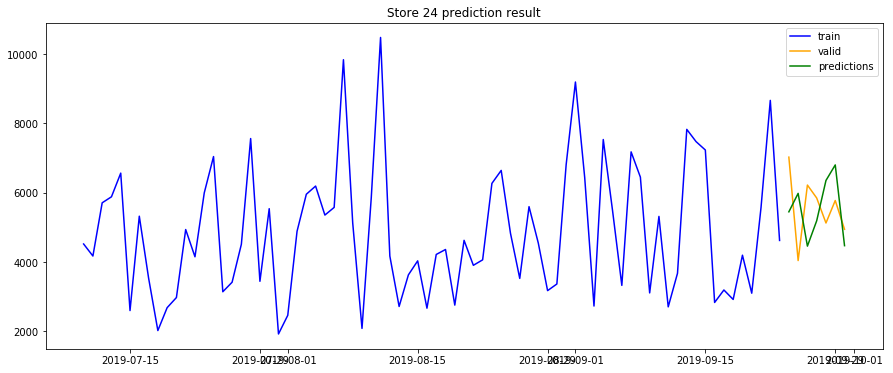

Order value for store 24 prediction is:

order :  (1, 1, 1)
seasonal_order :  (2, 0, 1, 7)


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/pyramid/arima/auto.py:379: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  'Falling back to stepwise parameter search.' % n_jobs)


Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 0, 1, 7); AIC=1366.102, BIC=1380.007, Fit time=0.269 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 0, 0, 7); AIC=1395.377, BIC=1400.012, Fit time=0.005 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 0, 0, 7); AIC=1383.263, BIC=1392.533, Fit time=0.023 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 0, 1, 7); AIC=1362.290, BIC=1371.560, Fit time=0.129 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 0, 1, 7); AIC=1364.177, BIC=1375.764, Fit time=0.183 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 0, 0, 7); AIC=1360.296, BIC=1367.248, Fit time=0.042 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 0, 0, 7); AIC=1361.443, BIC=1370.713, Fit time=0.099 seconds
Fit ARIMA: order=(0, 1, 2) seasonal_order=(0, 0, 0, 7); AIC=1362.317, BIC=1371.587, Fit time=0.077 seconds
Fit ARIMA: order=(1, 1, 2) seasonal_order=(0, 0, 0, 7); AIC=1360.992, BIC=1372.580, Fit time=0.096 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_o

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:3: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`
  app.launch_new_instance()
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:4: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`


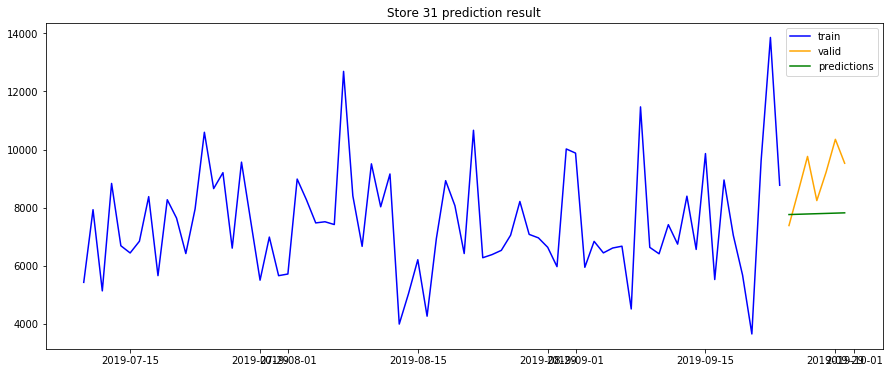

Order value for store 31 prediction is:

order :  (0, 1, 1)
seasonal_order :  (0, 0, 0, 7)


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/pyramid/arima/auto.py:379: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  'Falling back to stepwise parameter search.' % n_jobs)


Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 0, 1, 7); AIC=1486.047, BIC=1499.952, Fit time=0.630 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 0, 0, 7); AIC=1565.759, BIC=1570.394, Fit time=0.005 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 0, 0, 7); AIC=1538.694, BIC=1547.964, Fit time=0.032 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 0, 1, 7); AIC=1537.451, BIC=1546.721, Fit time=0.156 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 0, 1, 7); AIC=1530.349, BIC=1541.937, Fit time=0.223 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(2, 0, 1, 7); AIC=1486.333, BIC=1502.555, Fit time=1.005 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 0, 0, 7); AIC=1511.552, BIC=1523.139, Fit time=0.282 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 0, 2, 7); AIC=1486.785, BIC=1503.007, Fit time=0.761 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 0, 0, 7); AIC=1549.178, BIC=1558.447, Fit time=0.068 seconds


/home/ec2-user/.local/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:981: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


Fit ARIMA: order=(1, 1, 1) seasonal_order=(2, 0, 2, 7); AIC=1511.722, BIC=1530.261, Fit time=1.510 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 0, 1, 7); AIC=1496.633, BIC=1508.220, Fit time=0.513 seconds
Fit ARIMA: order=(2, 1, 1) seasonal_order=(1, 0, 1, 7); AIC=1487.973, BIC=1504.195, Fit time=0.862 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 0, 1, 7); AIC=1501.148, BIC=1512.736, Fit time=0.336 seconds


/home/ec2-user/.local/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:961: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Fit ARIMA: order=(1, 1, 2) seasonal_order=(1, 0, 1, 7); AIC=1488.015, BIC=1504.237, Fit time=0.601 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(1, 0, 1, 7); AIC=1508.284, BIC=1517.554, Fit time=0.228 seconds


/home/ec2-user/.local/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:961: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Fit ARIMA: order=(2, 1, 2) seasonal_order=(1, 0, 1, 7); AIC=1488.474, BIC=1507.014, Fit time=0.927 seconds
Total fit time: 8.144 seconds


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:3: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`
  app.launch_new_instance()
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:4: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`


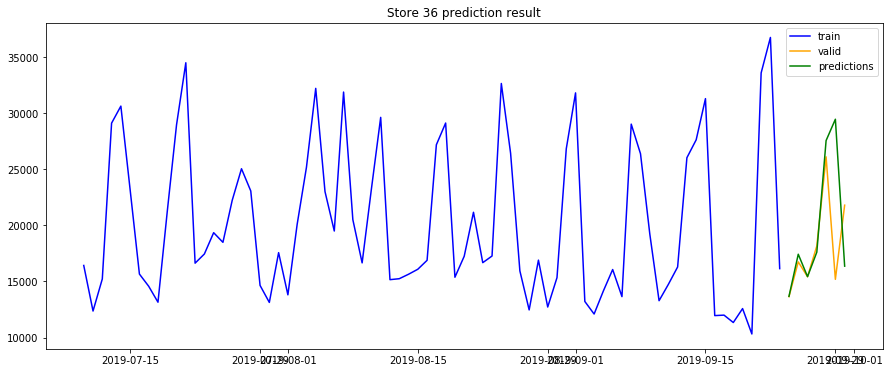

Order value for store 36 prediction is:

order :  (1, 1, 1)
seasonal_order :  (1, 0, 1, 7)


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/pyramid/arima/auto.py:379: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  'Falling back to stepwise parameter search.' % n_jobs)
/home/ec2-user/.local/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:993: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 0, 1, 7); AIC=1599.653, BIC=1613.558, Fit time=0.443 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 0, 0, 7); AIC=1683.947, BIC=1688.582, Fit time=0.005 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 0, 0, 7); AIC=1659.552, BIC=1668.822, Fit time=0.029 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 0, 1, 7); AIC=1649.707, BIC=1658.977, Fit time=0.229 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 0, 1, 7); AIC=1662.760, BIC=1674.348, Fit time=0.055 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(2, 0, 1, 7); AIC=1651.424, BIC=1667.647, Fit time=0.104 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 0, 0, 7); AIC=1622.463, BIC=1634.051, Fit time=0.395 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 0, 2, 7); AIC=1652.312, BIC=1668.534, Fit time=0.121 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 0, 0, 7); AIC=1676.700, BIC=1685.970, Fit time=0.028 seconds


/home/ec2-user/.local/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:981: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/home/ec2-user/.local/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:993: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


Fit ARIMA: order=(1, 1, 1) seasonal_order=(2, 0, 2, 7); AIC=1653.422, BIC=1671.962, Fit time=0.170 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 0, 1, 7); AIC=1599.172, BIC=1610.759, Fit time=0.494 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(1, 0, 1, 7); AIC=1650.288, BIC=1659.558, Fit time=0.045 seconds


/home/ec2-user/.local/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:993: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
/home/ec2-user/.local/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:961: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/ec2-user/.local/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:993: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


Fit ARIMA: order=(0, 1, 2) seasonal_order=(1, 0, 1, 7); AIC=1598.488, BIC=1612.393, Fit time=0.448 seconds


/home/ec2-user/.local/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:961: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/ec2-user/.local/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:993: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


Fit ARIMA: order=(1, 1, 2) seasonal_order=(1, 0, 1, 7); AIC=1599.351, BIC=1615.574, Fit time=0.748 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(2, 0, 1, 7); AIC=1650.523, BIC=1664.428, Fit time=0.095 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 0, 0, 7); AIC=1621.549, BIC=1630.819, Fit time=0.172 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 0, 2, 7); AIC=1651.237, BIC=1665.141, Fit time=0.101 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 0, 0, 7); AIC=1686.005, BIC=1692.958, Fit time=0.013 seconds


/home/ec2-user/.local/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:981: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


Fit ARIMA: order=(0, 1, 1) seasonal_order=(2, 0, 2, 7); AIC=1609.089, BIC=1625.311, Fit time=1.244 seconds
Total fit time: 4.945 seconds


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:3: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`
  app.launch_new_instance()
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:4: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`


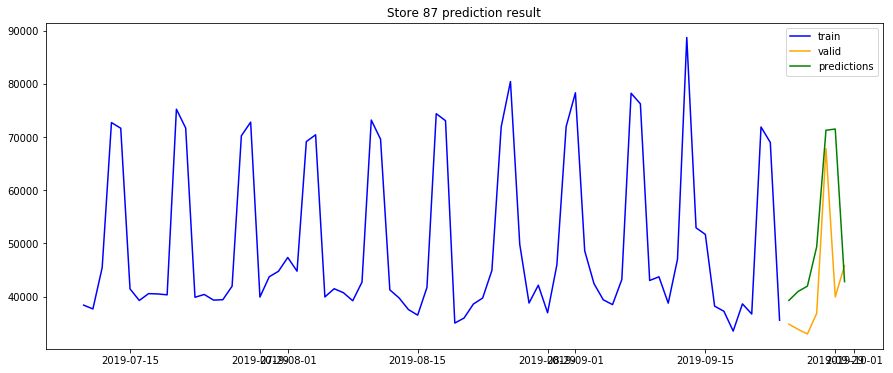

Order value for store 87 prediction is:

order :  (0, 1, 1)
seasonal_order :  (1, 0, 1, 7)


In [27]:
for i in sample_sites:
    ts = timeseries[i]
    df_train = ts[start_dataset:start_predict-1]
    df_predict=ts[start_predict:end_predict-1]
    model = auto_arima(df_train, trace=True, seasonal=True, d=1, start_p=1, max_p =10, start_q=1, max_q=10, m=7, maxiter=500, random=False, n_fits=100, n_jobs =8, information_criterion ='bic', error_action='ignore', suppress_warning=True)
    forecast = model.predict(n_periods=7)
    order = model.get_params()["order"]
    seasonal_order = model.get_params()["seasonal_order"]
    plot_predictions(forecast, i)
    print('Order value for store %s prediction is:\n' %i)
    print('order : ', order)
    print('seasonal_order : ', seasonal_order)